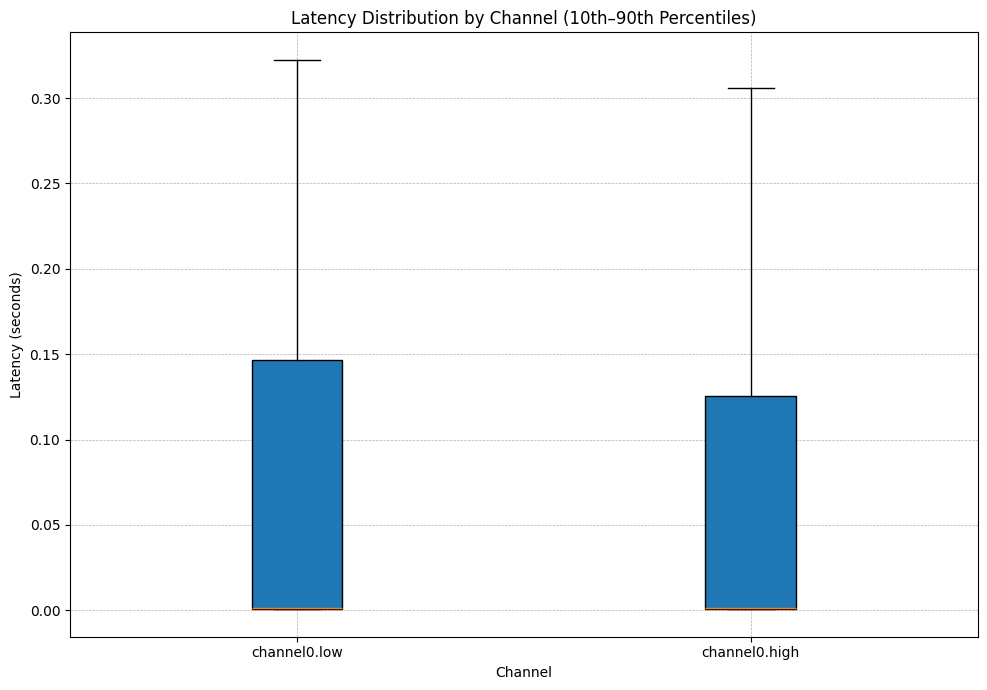

In [27]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

# Read the file as a plain text file (each line becomes a row)
with open('latency_metrics_dispatcher_1.txt', 'r') as f:
    lines = f.readlines()

# Extract channel and latency from each line using regex
data = []
for line in lines:
    match = re.search(r'Latency in (\S+): ([\d.]+) seconds', line)
    if match:
        channel = match.group(1)
        latency = float(match.group(2))
        data.append({'channel': channel, 'latency': latency})

# Convert to DataFrame
df = pd.DataFrame(data)

# Get unique channels
channels = df['channel'].unique()

# Prepare custom boxplot stats using 10th–90th percentiles
box_data = []
for ch in channels:
    latencies = df[df['channel'] == ch]['latency'].values
    stats = {
        'label': ch,
        'whislo': np.percentile(latencies, 10),   # 10th percentile
        'q1': np.percentile(latencies, 25),
        'med': np.percentile(latencies, 50),
        'q3': np.percentile(latencies, 75),
        'whishi': np.percentile(latencies, 90),   # 90th percentile
        'fliers': []  # No outliers shown
    }
    box_data.append(stats)

# Plot custom boxplot
plt.figure(figsize=(10, 7))
plt.title("Latency Distribution by Channel (10th–90th Percentiles)")
plt.xlabel("Channel")
plt.ylabel("Latency (seconds)")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Draw the boxplot
plt.boxplot(
    [df[df['channel'] == ch]['latency'] for ch in channels],
    tick_labels=channels,
    showfliers=False,
    widths=0.2,
    patch_artist=True
)

# Optional: annotate percentiles manually if desired (optional)

plt.show()


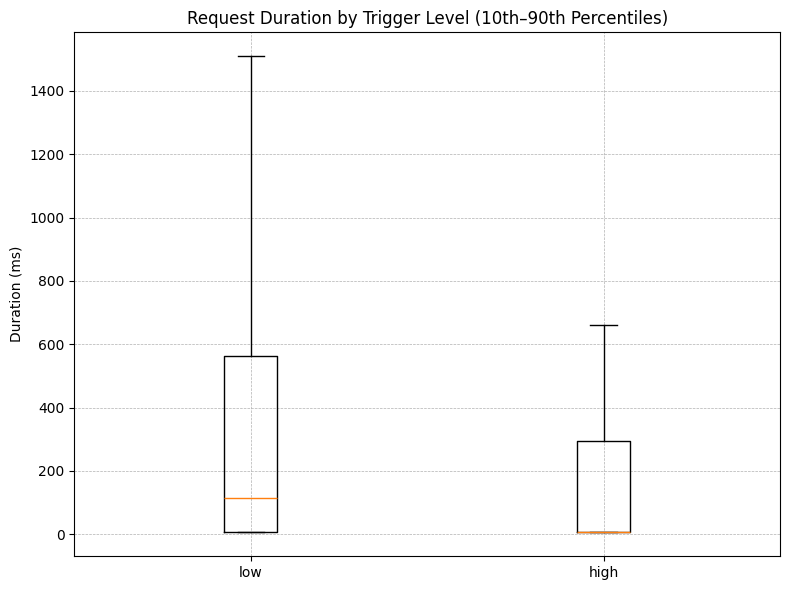

In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your JSON file
with open("traces-1753434179515.json") as f:
    trace_data = json.load(f)

trace_timings = []

# Extract duration and trigger level
for trace in trace_data["data"]:
    trace_id = trace["traceID"]
    start_times = []
    end_times = []
    trigger_level = None

    for span in trace["spans"]:
        start = span["startTime"]
        duration = span["duration"]
        end = start + duration
        start_times.append(start)
        end_times.append(end)

        for tag in span.get("tags", []):
            if tag["key"] == "trigger.level":
                trigger_level = tag["value"]

    if start_times and end_times:
        total_duration_us = max(end_times) - min(start_times)
        total_duration_ms = total_duration_us / 1000
        trace_timings.append({
            "trace_id": trace_id,
            "duration_ms": total_duration_ms,
            "trigger_level": trigger_level or "unknown"
        })

# Convert to DataFrame
df = pd.DataFrame(trace_timings)

# Optional label swap
label_map = {"high": "low", "low": "high", "unknown": "unknown"}

# Get unique trigger levels
levels = df["trigger_level"].unique()

# Prepare custom boxplot stats with swapped labels
box_data = []
for lvl in levels:
    durations = df[df["trigger_level"] == lvl]["duration_ms"].values
    stats = {
        'label': label_map.get(lvl, lvl),  # Swap label here
        'whislo': np.percentile(durations, 10),  # 10th percentile
        'q1':     np.percentile(durations, 25),
        'med':    np.percentile(durations, 50),
        'q3':     np.percentile(durations, 75),
        'whishi': np.percentile(durations, 90),  # 90th percentile
        'fliers': []  # No outliers
    }
    box_data.append(stats)

# Plot using matplotlib’s low-level function
fig, ax = plt.subplots(figsize=(8, 6))
ax.bxp(box_data, showfliers=False)  # No need to reverse if just swapping labels

ax.set_title("Request Duration by Trigger Level (10th–90th Percentiles)")
ax.set_ylabel("Duration (ms)")
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
